<a href="https://colab.research.google.com/github/ThijsVercammen/Masterproef/blob/main/YOLO_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installeer nodige tools en download YoloV3 gewichten en darknet architectuur

In [ ]:
%%shell
pip install onnx
wget https://pjreddie.com/media/files/yolov3.weights 
wget https://machinelearningmastery.com/wp-content/uploads/2019/03/zebra.jpg
git clone https://github.com/ayooshkathuria/YOLO_v3_tutorial_from_scratch.git
cd YOLO_v3_tutorial_from_scratch
pip install onnxruntime

git clone https://github.com/pdollar/coco/
cd coco/PythonAPI
make
python setup.py install
cd ../..
rm -r coco

Voer de gedownloade code uit zodat we de gewichten kunnen inladen

In [ ]:
from __future__ import division

import torch 
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
import numpy as np
from YOLO_v3_tutorial_from_scratch.util import * 

def parse_cfg(cfgfile):
    """
    Takes a configuration file
    
    Returns a list of blocks. Each blocks describes a block in the neural
    network to be built. Block is represented as a dictionary in the list
    
    """
    
    file = open(cfgfile, 'r')
    lines = file.read().split('\n')                        # store the lines in a list
    lines = [x for x in lines if len(x) > 0]               # get read of the empty lines 
    lines = [x for x in lines if x[0] != '#']              # get rid of comments
    lines = [x.rstrip().lstrip() for x in lines]           # get rid of fringe whitespaces
    
    block = {}
    blocks = []
    
    for line in lines:
        if line[0] == "[":               # This marks the start of a new block
            if len(block) != 0:          # If block is not empty, implies it is storing values of previous block.
                blocks.append(block)     # add it the blocks list
                block = {}               # re-init the block
            block["type"] = line[1:-1].rstrip()     
        else:
            key,value = line.split("=") 
            block[key.rstrip()] = value.lstrip()
    blocks.append(block)
    
    return blocks

class EmptyLayer(nn.Module):
    def __init__(self):
        super(EmptyLayer, self).__init__()
        
class DetectionLayer(nn.Module):
    def __init__(self, anchors):
        super(DetectionLayer, self).__init__()
        self.anchors = anchors

def create_modules(blocks):
    net_info = blocks[0]     #Captures the information about the input and pre-processing    
    module_list = nn.ModuleList()
    prev_filters = 3
    output_filters = []
    
    for index, x in enumerate(blocks[1:]):
        module = nn.Sequential()
    
        #check the type of block
        #create a new module for the block
        #append to module_list
        
        #If it's a convolutional layer
        if (x["type"] == "convolutional"):
            #Get the info about the layer
            activation = x["activation"]
            try:
                batch_normalize = int(x["batch_normalize"])
                bias = False
            except:
                batch_normalize = 0
                bias = True
        
            filters= int(x["filters"])
            padding = int(x["pad"])
            kernel_size = int(x["size"])
            stride = int(x["stride"])
        
            if padding:
                pad = (kernel_size - 1) // 2
            else:
                pad = 0
        
            #Add the convolutional layer
            conv = nn.Conv2d(prev_filters, filters, kernel_size, stride, pad, bias = bias)
            module.add_module("conv_{0}".format(index), conv)
        
            #Add the Batch Norm Layer
            if batch_normalize:
                bn = nn.BatchNorm2d(filters)
                module.add_module("batch_norm_{0}".format(index), bn)
        
            #Check the activation. 
            #It is either Linear or a Leaky ReLU for YOLO
            if activation == "leaky":
                activn = nn.LeakyReLU(0.1, inplace = True)
                module.add_module("leaky_{0}".format(index), activn)
        
            #If it's an upsampling layer
            #We use Bilinear2dUpsampling
        elif (x["type"] == "upsample"):
            stride = int(x["stride"])
            upsample = nn.Upsample(scale_factor = 2, mode = "nearest")
            module.add_module("upsample_{}".format(index), upsample)
                
        #If it is a route layer
        elif (x["type"] == "route"):
            x["layers"] = x["layers"].split(',')
            #Start  of a route
            start = int(x["layers"][0])
            #end, if there exists one.
            try:
                end = int(x["layers"][1])
            except:
                end = 0
            #Positive anotation
            if start > 0: 
                start = start - index
            if end > 0:
                end = end - index
            route = EmptyLayer()
            module.add_module("route_{0}".format(index), route)
            if end < 0:
                filters = output_filters[index + start] + output_filters[index + end]
            else:
                filters= output_filters[index + start]
    
        #shortcut corresponds to skip connection
        elif x["type"] == "shortcut":
            shortcut = EmptyLayer()
            module.add_module("shortcut_{}".format(index), shortcut)
            
        #Yolo is the detection layer
        elif x["type"] == "yolo":
            mask = x["mask"].split(",")
            mask = [int(x) for x in mask]
    
            anchors = x["anchors"].split(",")
            anchors = [int(a) for a in anchors]
            anchors = [(anchors[i], anchors[i+1]) for i in range(0, len(anchors),2)]
            anchors = [anchors[i] for i in mask]
    
            detection = DetectionLayer(anchors)
            module.add_module("Detection_{}".format(index), detection)
                              
        module_list.append(module)
        prev_filters = filters
        output_filters.append(filters)
        
    return (net_info, module_list)

class Darknet(nn.Module):
    def __init__(self, cfgfile):
        super(Darknet, self).__init__()
        self.blocks = parse_cfg(cfgfile)
        self.net_info, self.module_list = create_modules(self.blocks)
        
    def forward(self, x):
        CUDA = False
        modules = self.blocks[1:]
        outputs = {}   #We cache the outputs for the route layer
        
        write = 0
        for i, module in enumerate(modules):        
            module_type = (module["type"])
            
            if module_type == "convolutional" or module_type == "upsample":
                conv_1 = self.module_list[i]
                x = conv_1(x)
    
            elif module_type == "route":
                layers = module["layers"]
                layers = [int(a) for a in layers]
    
                if (layers[0]) > 0:
                    layers[0] = layers[0] - i
    
                if len(layers) == 1:
                    x = outputs[i + (layers[0])]
    
                else:
                    if (layers[1]) > 0:
                        layers[1] = layers[1] - i
    
                    map1 = outputs[i + layers[0]]
                    map2 = outputs[i + layers[1]]
                    x = torch.cat((map1, map2), 1)
                
    
            elif  module_type == "shortcut":
                from_ = int(module["from"])
                x = outputs[i-1] + outputs[i+from_]
    
            elif module_type == 'yolo':        
                anchors = self.module_list[i][0].anchors
                #Get the input dimensions
                inp_dim = int (self.net_info["height"])
        
                #Get the number of classes
                num_classes = int (module["classes"])
        
                #Transform 
                x = x.data
                x = predict_transform(x, inp_dim, anchors, num_classes, CUDA)
                if not write:              #if no collector has been intialised. 
                    detections = x
                    write = 1
        
                else:       
                    detections = torch.cat((detections, x), 1)
        
            outputs[i] = x
        
        return detections


    def load_weights(self, weightfile):
        #Open the weights file
        fp = open(weightfile, "rb")
    
        #The first 5 values are header information 
        # 1. Major version number
        # 2. Minor Version Number
        # 3. Subversion number 
        # 4,5. Images seen by the network (during training)
        header = np.fromfile(fp, dtype = np.int32, count = 5)
        self.header = torch.from_numpy(header)
        self.seen = self.header[3]   
        
        weights = np.fromfile(fp, dtype = np.float32)
        
        ptr = 0
        for i in range(len(self.module_list)):
            module_type = self.blocks[i + 1]["type"]
    
            #If module_type is convolutional load weights
            #Otherwise ignore.
            
            if module_type == "convolutional":
                model = self.module_list[i]
                try:
                    batch_normalize = int(self.blocks[i+1]["batch_normalize"])
                except:
                    batch_normalize = 0
            
                conv = model[0]
                
                
                if (batch_normalize):
                    bn = model[1]
        
                    #Get the number of weights of Batch Norm Layer
                    num_bn_biases = bn.bias.numel()
        
                    #Load the weights
                    bn_biases = torch.from_numpy(weights[ptr:ptr + num_bn_biases])
                    ptr += num_bn_biases
        
                    bn_weights = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
        
                    bn_running_mean = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
        
                    bn_running_var = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
        
                    #Cast the loaded weights into dims of model weights. 
                    bn_biases = bn_biases.view_as(bn.bias.data)
                    bn_weights = bn_weights.view_as(bn.weight.data)
                    bn_running_mean = bn_running_mean.view_as(bn.running_mean)
                    bn_running_var = bn_running_var.view_as(bn.running_var)
        
                    #Copy the data to model
                    bn.bias.data.copy_(bn_biases)
                    bn.weight.data.copy_(bn_weights)
                    bn.running_mean.copy_(bn_running_mean)
                    bn.running_var.copy_(bn_running_var)
                
                else:
                    #Number of biases
                    num_biases = conv.bias.numel()
                
                    #Load the weights
                    conv_biases = torch.from_numpy(weights[ptr: ptr + num_biases])
                    ptr = ptr + num_biases
                
                    #reshape the loaded weights according to the dims of the model weights
                    conv_biases = conv_biases.view_as(conv.bias.data)
                
                    #Finally copy the data
                    conv.bias.data.copy_(conv_biases)
                    
                #Let us load the weights for the Convolutional layers
                num_weights = conv.weight.numel()
                
                #Do the same as above for weights
                conv_weights = torch.from_numpy(weights[ptr:ptr+num_weights])
                ptr = ptr + num_weights
                
                conv_weights = conv_weights.view_as(conv.weight.data)
                conv.weight.data.copy_(conv_weights)

configureer het model en laad de YoloV3 gewichten

In [ ]:
model = Darknet("/content/YOLO_v3_tutorial_from_scratch/cfg/yolov3.cfg")
model.load_weights("/content/yolov3.weights")

Voer het model uit op een test afbeelding

In [ ]:
def rotate_box(corners,angle,  cx, cy, h, w):
    corners = corners.reshape(-1,2)
    corners = np.hstack((corners, np.ones((corners.shape[0],1), dtype = type(corners[0][0]))))
    
    M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
    
    
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cx
    M[1, 2] += (nH / 2) - cy
    # Prepare the vector to be transformed
    calculated = np.dot(M,corners.T).T
    
    calculated = calculated.reshape(-1,4)
    
    return calculated		


def post_process(output, width, height):
  if len(output) > 0:
    for  i in output:
      array = np.array([[i[2], i[1], i[4], i[3]]])
      w1, h1 = i[4] - i[2], i[3] - i[1]
      cx, cy = 416/2, 416/2
      rotation_angle =  0
      calc = rotate_box(array, rotation_angle, cx, cy, 416, 416)
      box = calc

      i[1] = (box[0][0]/416)*height
      i[2] = (box[0][1]/416)*width
      i[3] = (box[0][2]/416)*height
      i[4] = (box[0][3]/416)*width
  
  return output


In [ ]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle
import scipy.ndimage as ndimage

def draw_boxes(filename, v_boxes):
	# load the image
	data = pyplot.imread(filename)
	#angle = -90 # in degrees
	#data = ndimage.rotate(data, angle, reshape=True)
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box[1], box[2], box[3], box[4]
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_boxes[i][7], v_boxes[i][6])
		pyplot.text(x1, y1, label, color='white')
	# show the plot
	pyplot.show()

Snelheid: 0:00:01.493315
Snelheid: 0:00:01.543801


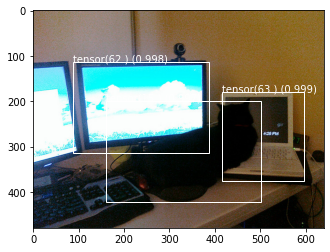

tensor([[[2.1909e+01, 1.3980e+01, 1.0609e+02,  ..., 5.7185e-04,
          3.0839e-05, 3.0517e-05],
         [2.7412e+01, 7.6250e+00, 9.5389e+01,  ..., 8.7938e-06,
          2.2818e-05, 2.1224e-05],
         [1.4068e+01, 5.1020e+00, 4.4864e+02,  ..., 2.4176e-05,
          3.7004e-05, 9.3811e-05],
         ...,
         [4.1194e+02, 4.1214e+02, 7.5994e+00,  ..., 7.0607e-03,
          1.1521e-03, 1.3477e-03],
         [4.1197e+02, 4.1090e+02, 8.0150e+00,  ..., 1.3992e-02,
          1.9722e-03, 1.0338e-03],
         [4.1089e+02, 4.1237e+02, 6.6014e+01,  ..., 8.5333e-03,
          2.5829e-03, 1.0444e-03]]])

In [ ]:
from YOLO_v3_tutorial_from_scratch.util import write_results
from PIL import Image
import numpy as np
import torchvision
import math
import cv2
from datetime import datetime

im = Image.open("/content/val2017/000000198641.jpg")
res_im = im.resize((416, 416))

width = im.width
height = im.height

convert_tensor = torchvision.transforms.ToTensor()
a = convert_tensor(res_im)
b = a.unsqueeze(0)

now = datetime.now()
out = model(b)
print("Snelheid: {}".format(datetime.now()-now))

out1 = write_results(out, 0.5, 80, 0.6)
output_p = post_process(out1, width, height)
print("Snelheid: {}".format(datetime.now()-now))
draw_boxes("/content/val2017/000000198641.jpg", output_p)

Converteer het model naar PyTorch Mobile

In [ ]:
from torch.utils.mobile_optimizer import optimize_for_mobile
import torch
from PIL import Image
import torchvision

im = Image.open("/content/zebra.jpg").resize((416, 416))
convert_tensor = torchvision.transforms.ToTensor()(im)
b = convert_tensor.unsqueeze(0)
example = torch.rand(1,3,416,416)

model.eval()
traced_script_module = torch.jit.trace(model,b)
traced_script_module.save('./model.pt')
traced_script_module_optimized = optimize_for_mobile(traced_script_module)
traced_script_module_optimized.save('./model1.pt')
traced_script_module_optimized._save_for_lite_interpreter("./model_s.pt")

Test PyTorch Mobile model

Snelheid: 0:00:00.314231


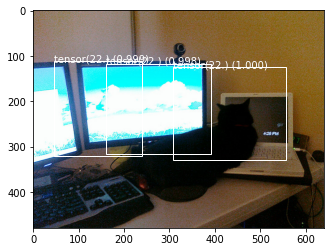

tensor([[  0.0000, 112.0783,  44.8183, 320.8415, 240.0886,   0.9988,   0.9990,
          22.0000],
        [  0.0000, 125.3014, 307.1035, 328.2173, 555.6601,   0.9717,   0.9996,
          22.0000],
        [  0.0000, 118.3732, 160.4400, 314.9486, 391.5508,   0.9439,   0.9978,
          22.0000]])

In [ ]:
im = Image.open("/content/val2017/000000198641.jpg")
res_im = im.resize((416, 416))

width = im.width
height = im.height

convert_tensor = torchvision.transforms.ToTensor()
ten = convert_tensor(res_im)
b = ten.unsqueeze(0)

now = datetime.now()
out_s = traced_script_mod(b)
print("Snelheid: {}".format(datetime.now()-now))

out_s_nms = write_results(out_s, 0.5, 80, 0.4)
result = post_process(out_s_nms, width, height)
print("Snelheid: {}".format(datetime.now()-now))
draw_boxes("/content/val2017/000000198641.jpg", result)


Converteer PyTorch model naar ONNX model

In [ ]:
im = Image.open("/content/zebra.jpg")
res_im = im.resize((416, 416))

width = im.width
height = im.height

convert_tensor = torchvision.transforms.ToTensor()
a = convert_tensor(res_im)
b = a.unsqueeze(0)
model.eval()

torch.onnx.export(model,               # model being run
                  b,                         # model input (or a tuple for multiple inputs)
                  "model_py.onnx",   # where to save the model (can be a file or file-like object)
                  opset_version=11,         # the ONNX version to export the model to
                  input_names = ["input", "iets"],   # the model's input names
                  output_names = ['output'],
                  )